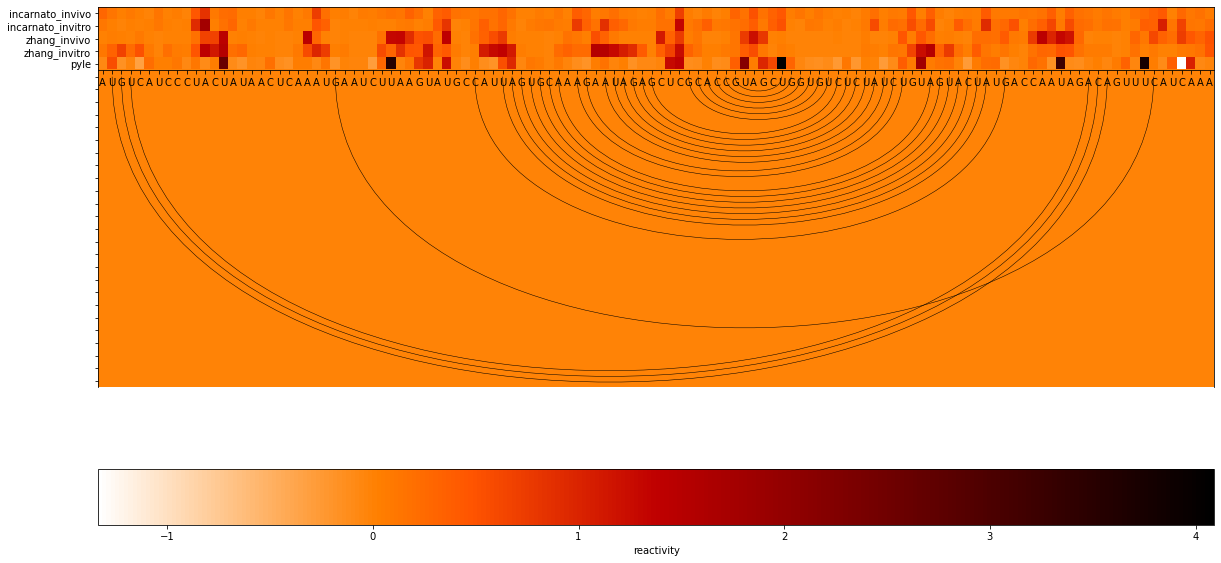

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Path,PathPatch
from arnie.utils import *

import sys
from arnie.mfe import mfe
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
nan = np.nan

#Replace '-999'in shape data to nan 
def shape_lines_unnorm(shape_lines):
    all_shape_lines_no_nan = []
    for number in shape_lines:
        if number == '-999\n':
            all_shape_lines_no_nan.append('nan')
        elif number =='nan\n':
             all_shape_lines_no_nan.append('nan')
        elif number =='nan': #line added for 'nan' in dms shape
             all_shape_lines_no_nan.append('nan')
        else:
            all_shape_lines_no_nan.append(float(number))   
    #float_lines=[float(i) for i in all_shape_lines_no_nan]
    return (all_shape_lines_no_nan)

#Normalizing the shape data
def normalize_shape(shape_reacs):
    shape_reacs = np.array(shape_reacs)

    # Get rid of nan values for now
    nonan_shape_reacs = shape_reacs[~np.isnan(shape_reacs)]

    # Find Filter 1: 1.5 * Inter-Quartile Range
    sorted_shape = np.sort(nonan_shape_reacs)
    q1 = sorted_shape[int(0.25 * len(sorted_shape))]
    q3 = sorted_shape[int(0.75 * len(sorted_shape))]
    iq_range = abs(q3 - q1)
    filter1 = next(x for x, val in \
        enumerate(list(sorted_shape)) if val > 1.5 * iq_range)

    # Find Filter 2: 95% value
    filter2 = int(0.95 * len(sorted_shape))

    # Get maximum filter value and fiter data
    filter_cutoff = sorted_shape[max(filter1, filter2)]
    sorted_shape = sorted_shape[sorted_shape < filter_cutoff]

    # Scalefactor: Mean of top 10th percentile of values
    top90 = sorted_shape[int(0.9 * len(sorted_shape))]
    scalefactor = np.mean(sorted_shape[sorted_shape > top90])
        
    # Scale dataset
    return shape_reacs/scalefactor
    
# input is text file of any shape data set, output is normalized list of values in a list
def get_normalized_shape_data(shape_filename):

    # write shape text file to list
    shape_file = open("{}".format(shape_filename), "r")
    shape_data = shape_file.read()
    shape_data_list = shape_data.split("\n")
    shape_file.close()
    
    for char in shape_data_list:
        if char == '':
            shape_data_list.remove('')

    #convert unknown values to string 'nan'
    shape_nan_list = shape_lines_unnorm(shape_data_list)
    
    #convert string 'nan' to np.nan
    shape_reacs = []
    for char in shape_nan_list:
        if char == 'nan':
            shape_reacs.append(np.nan)
        else:
            shape_reacs.append(char)
    
    # normalize shape data
    normalized_shape_data = normalize_shape(shape_reacs).tolist()
    return normalized_shape_data


    
df = pd.read_csv('/home/gnye8/Desktop/PK_research/pipeline_results/analysis_output/top_pks.csv')
incarnato_invivo = get_normalized_shape_data('/home/gnye8/Desktop/PK_research/SSRP_work/shape_data/incarnato_invivo_reactivity.csv')
incarnato_invitro = get_normalized_shape_data('/home/gnye8/Desktop/PK_research/SSRP_work/shape_data/incarnato_invitro_reactivity.csv')
zhang_invivo = get_normalized_shape_data('/home/gnye8/Desktop/PK_research/SSRP_work/shape_data/zhang_invivo_reactivity.csv')
zhang_invitro = get_normalized_shape_data('/home/gnye8/Desktop/PK_research/SSRP_work/shape_data/zhang_invitro_reactivity.csv')
pyle = get_normalized_shape_data('/home/gnye8/Desktop/PK_research/SSRP_work/shape_data/pyle_reactivity.csv')

starts = df['start'].to_list()
seqs = df['sequence'].to_list()
structs = df['structure'].to_list()

shapes_incarnato_invivo = []
for idx in starts: 
    shape_data = incarnato_invivo[idx:idx+120]
    shapes_incarnato_invivo.append(shape_data)

shapes_incarnato_invitro = []
for idx in starts: 
    shape_data = incarnato_invitro[idx:idx+120]
    shapes_incarnato_invitro.append(shape_data)
    
shapes_zhang_invivo = []
for idx in starts: 
    shape_data = zhang_invivo[idx:idx+120]
    shapes_zhang_invivo.append(shape_data)
    
    
shapes_zhang_invitro = []
for idx in starts: 
    shape_data = zhang_invitro[idx:idx+120]
    shapes_zhang_invitro.append(shape_data)
    
shapes_pyle = []
for idx in starts: 
    shape_data = pyle[idx:idx+120]
    shapes_pyle.append(shape_data)

def draw_contact(i, j, ax,ystart,size_multiple):
    size = size_multiple*(j - i)

    verts = [
       (i, ystart),   # P0
       (i, ystart+size),  # P1
       (j, ystart+size),  # P2
       (j, ystart),  # P3
    ]
    codes = [
        Path.MOVETO,
        Path.CURVE4,
        Path.CURVE4,
        Path.CURVE4,
    ]

    path = Path(verts, codes)

    patch = PathPatch(path, facecolor='none', lw=0.5)
    ax.add_patch(patch)

## INPUTS
seq = seqs[0]
struct = structs[0]
reacts = [shapes_incarnato_invivo[0], shapes_incarnato_invitro[0], shapes_zhang_invivo[0], shapes_zhang_invitro[0], shapes_pyle[0]]
react_labels = ["incarnato_invivo","incarnato_invitro", "zhang_invivo", "zhang_invitro", "pyle"]
num_white_space = 25 # increase if need more space at bottom for arc
figsize_x = 20
figsize_y = 10
arc_offset = 0 # increase if arc needs to move more down 
arc_height = 0.3 # decrease if want arc shorter


for i in range(num_white_space):
    reacts.append(np.zeros(len(seq)))
    react_labels.append("")

plt.figure(figsize=(figsize_x,figsize_y))

plt.imshow(reacts,cmap='gist_heat_r',aspect='auto')
g=plt.yticks(list(range(len(reacts))),react_labels)
g=plt.xticks(list(range(len(seq))),seq)
plt.gca().spines['bottom'].set_position(('data', len(reacts)-0.5-num_white_space))
bp_list = convert_dotbracket_to_bp_list(struct,allow_pseudoknots=True)
for i,j in bp_list:
    draw_contact(i,j,plt.gca(),len(reacts)-num_white_space-arc_offset,arc_height)

plt.colorbar(orientation='horizontal', label='reactivity')
plt.savefig('TEST.png',dpi=150, bbox_inches='tight')

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Path,PathPatch
from arnie.utils import *


def get_shape_graphs_for_pks(pk_csv, path_to_shape_data, list_of_shape_sets, output_folder):
    df = pd.read_csv(pk_csv)
    
    all_shape_sets = []
    for name in list_of_shape_sets:
        shape_data = get_normalized_shape_data(path_to_shape_data + '/' + name + '.csv')
        float_shape_data = []
        for char in shape_data:
            if np.isnan(char):
                float_shape_data.append(float(-999))
            else:
                float_shape_data.append(float(char))
                
        all_shape_sets.append(float_shape_data)
        
        
    starts = df['start'].to_list()
    seqs = df['sequence'].to_list()
    structs = df['structure'].to_list()
    pk_predictor = df['program'].to_list()
    
    # generate a list containing sets of all programs with shape data with only pks of interest
    all_pk_shape_data = []
    for program in all_shape_sets:
        program_specific_pk_shape_data = []
        for idx in starts:
            pk_shape_data = program[idx:idx+120]
            program_specific_pk_shape_data.append(pk_shape_data)
        all_pk_shape_data.append(program_specific_pk_shape_data)
    
    
    # in this case we are investigating 39 pks
    # replace this with a variable to adjust the number to whatever csv is put in
    # for this pseudoknot, we are finding the sequence, the predicted structure
        # and a list with the shape data from all 5 tracks for that window
    for idx in range(0,39):
        seq = seqs[idx]
        struct = structs[idx]
        reacts = []
        for num in range(len(list_of_shape_sets)):
            # 'program' contains all the shape data for all windows with pks from one track of data
            program = all_pk_shape_data[num]
            # react contains the shape data from one window from one track of data
            react = program[idx]
            reacts.append(react)
            
        react_labels = []
        react_labels = react_labels + list_of_shape_sets
        num_white_space = 25 # increase if need more space at bottom for arc
        figsize_x = 20
        figsize_y = 10
        arc_offset = 0 # increase if arc needs to move more down 
        arc_height = 0.3 # decrease if want arc shorter


        for i in range(num_white_space):
            reacts.append(np.zeros(len(seq)))
            react_labels.append("")
    

        plt.figure(figsize=(figsize_x,figsize_y))

        plt.imshow(reacts,cmap='gist_heat_r',aspect='auto')
        g=plt.yticks(list(range(len(reacts))),react_labels)
        g=plt.xticks(list(range(len(seq))),seq)
        plt.gca().spines['bottom'].set_position(('data', len(reacts)-0.5-num_white_space))
        bp_list = convert_dotbracket_to_bp_list(struct,allow_pseudoknots=True)
        for i,j in bp_list:
            draw_contact(i,j,plt.gca(),len(reacts)-num_white_space-arc_offset,arc_height)

        plt.colorbar(orientation='horizontal', label='reactivity')
        plt.savefig(output_folder+'/'+str(starts[idx])+'_'+pk_predictor[idx]+'.png', dpi=150, bbox_inches='tight')

In [16]:
# note for troubleshooting: what value to give areas with no data?

<ipython-input-34-fb63f582d1c6>:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(figsize_x,figsize_y))


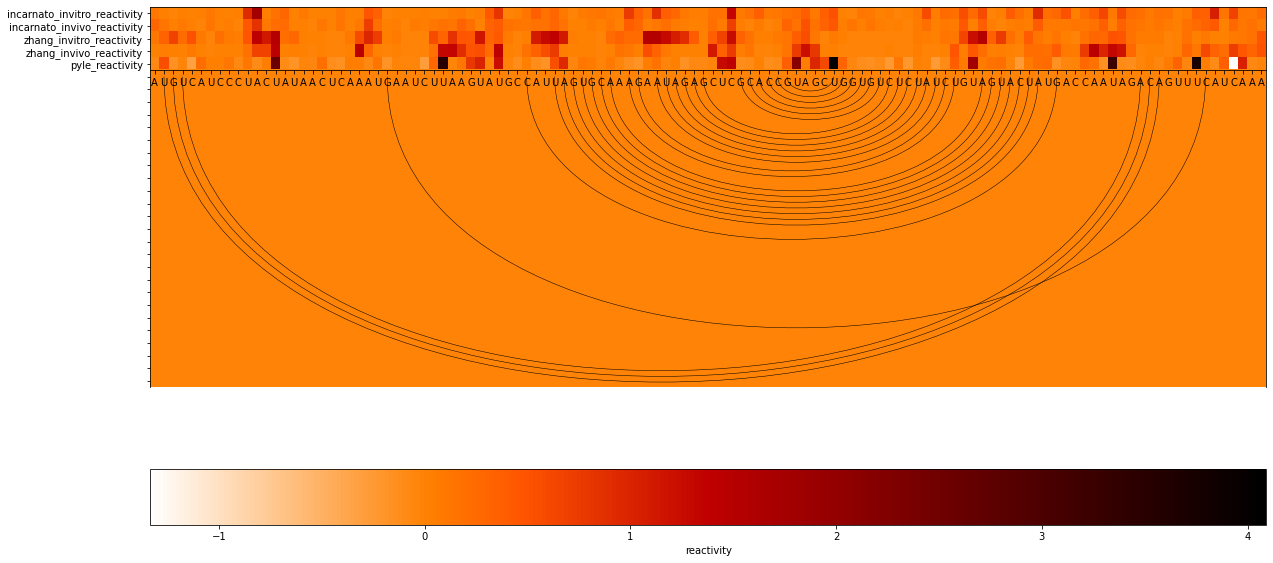

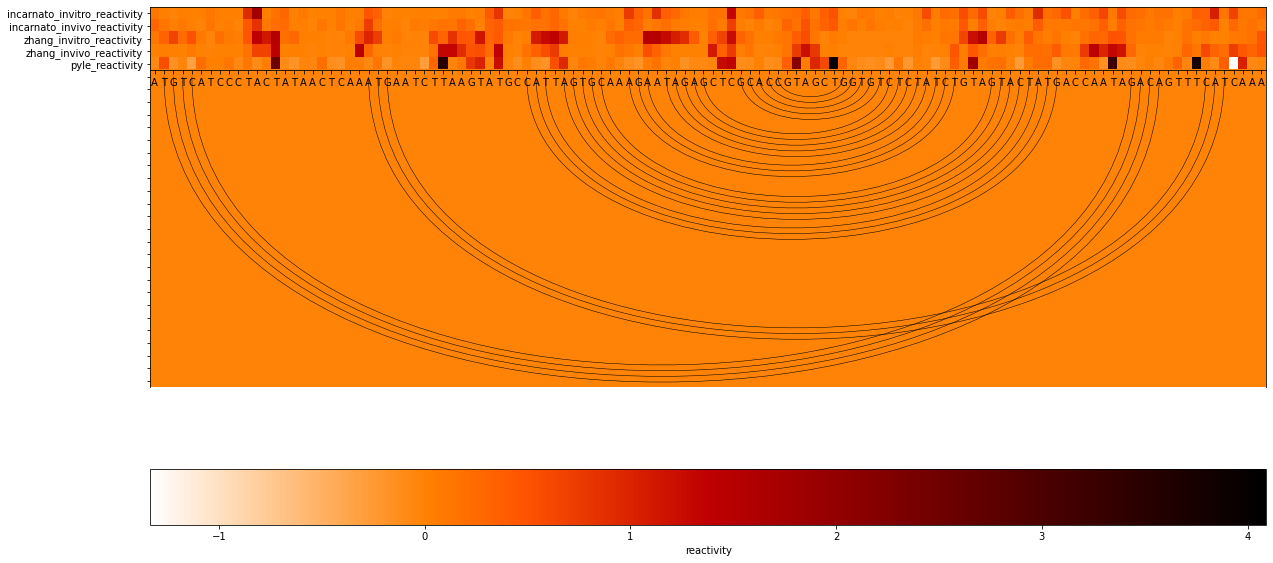

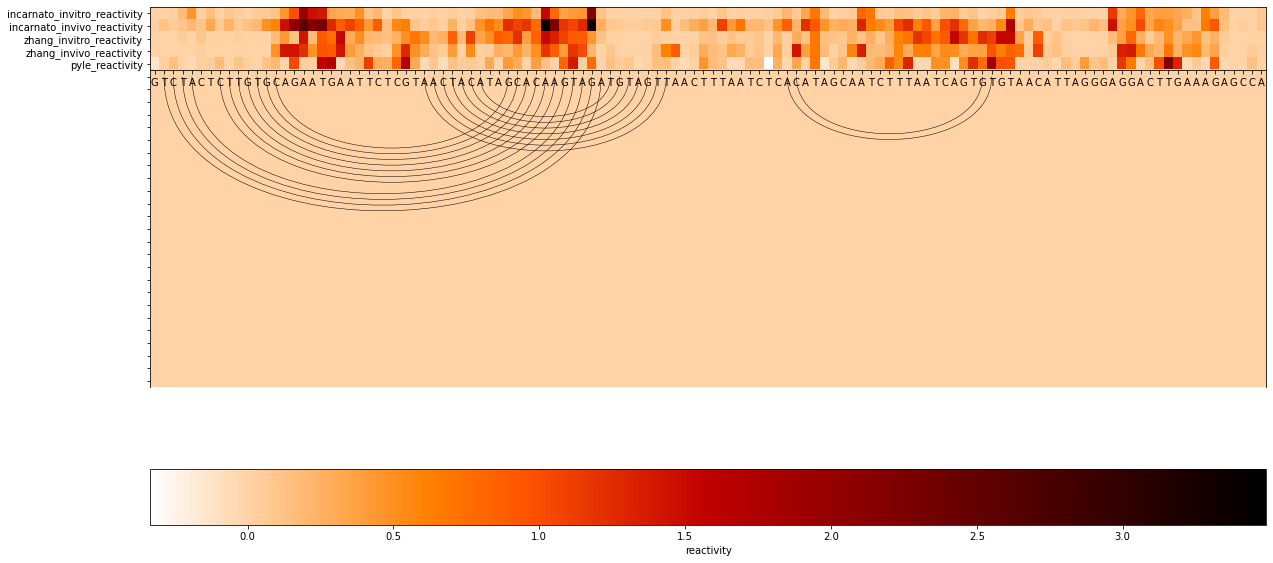

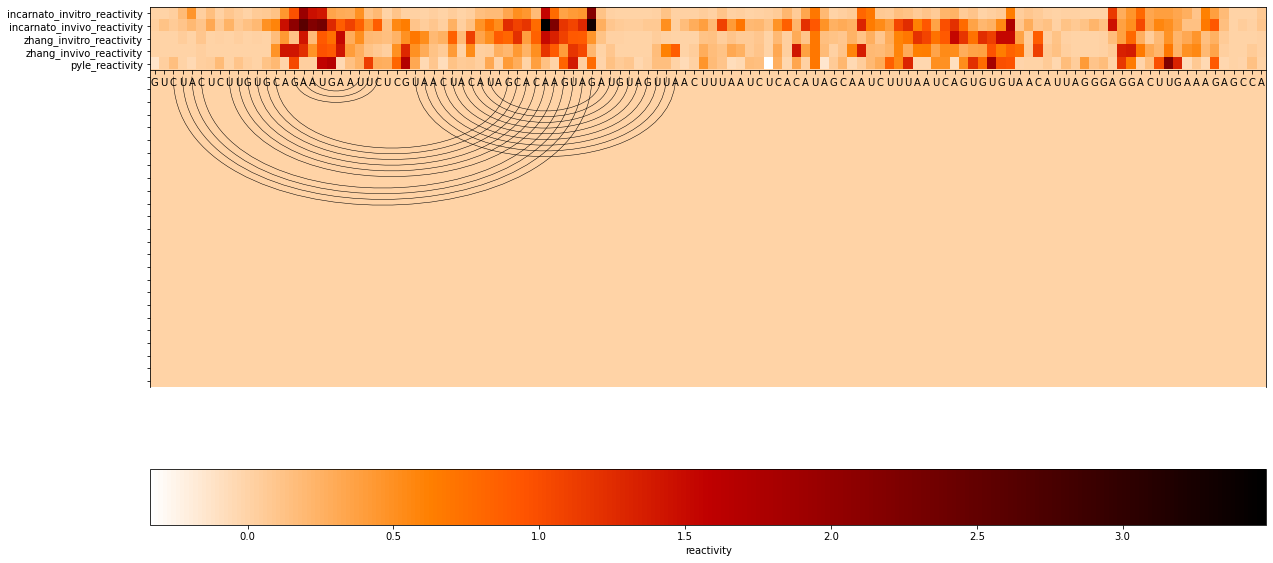

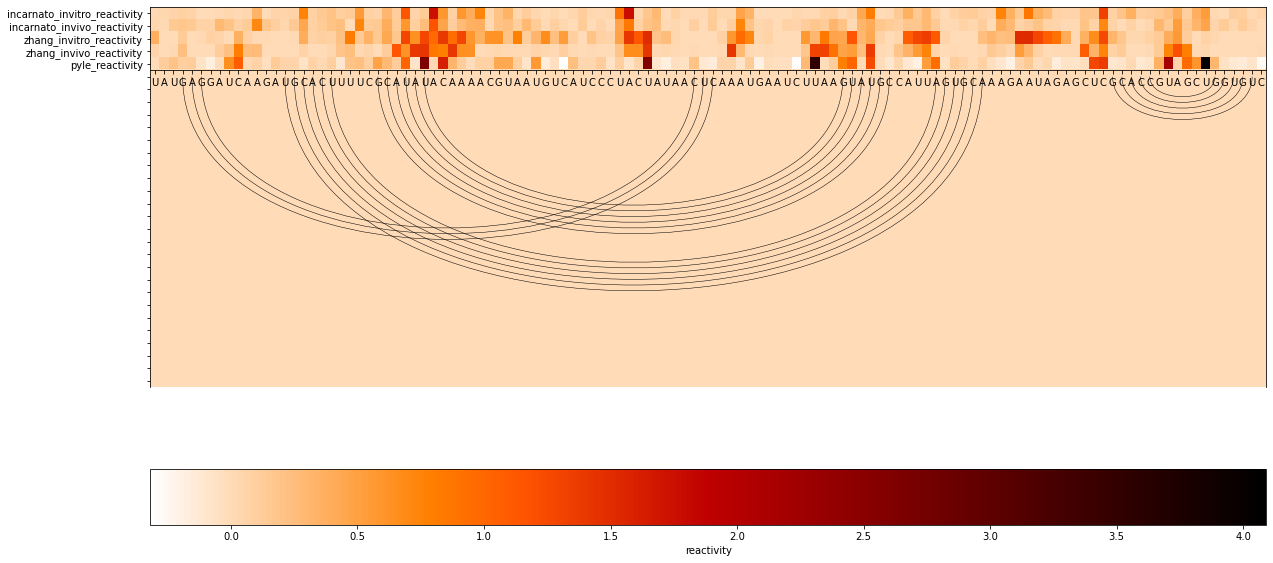

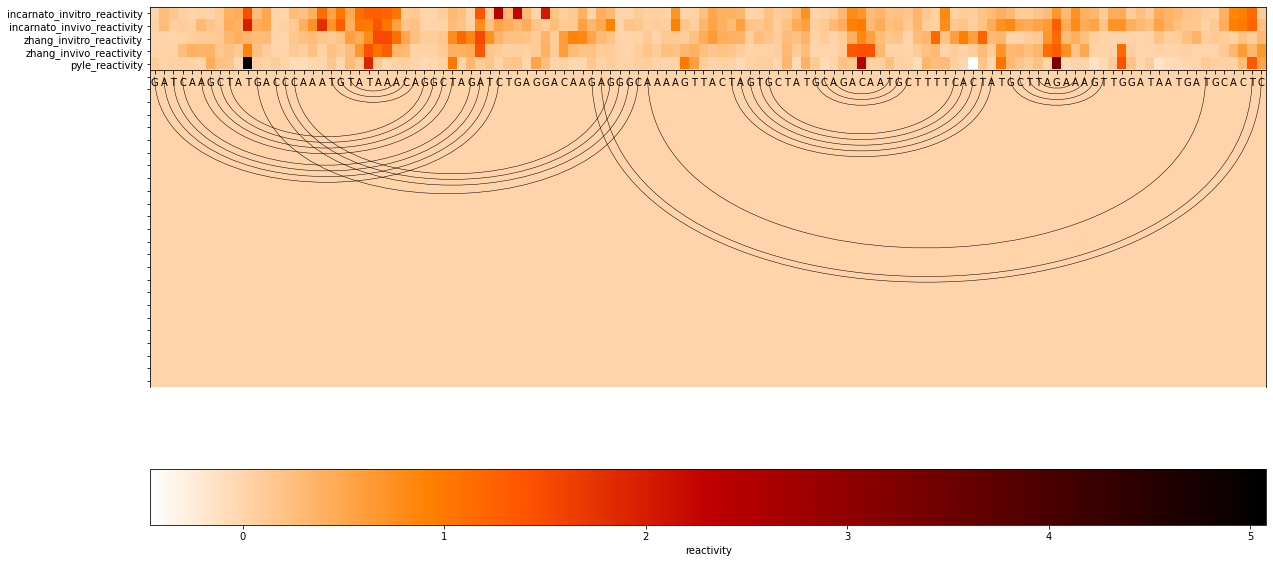

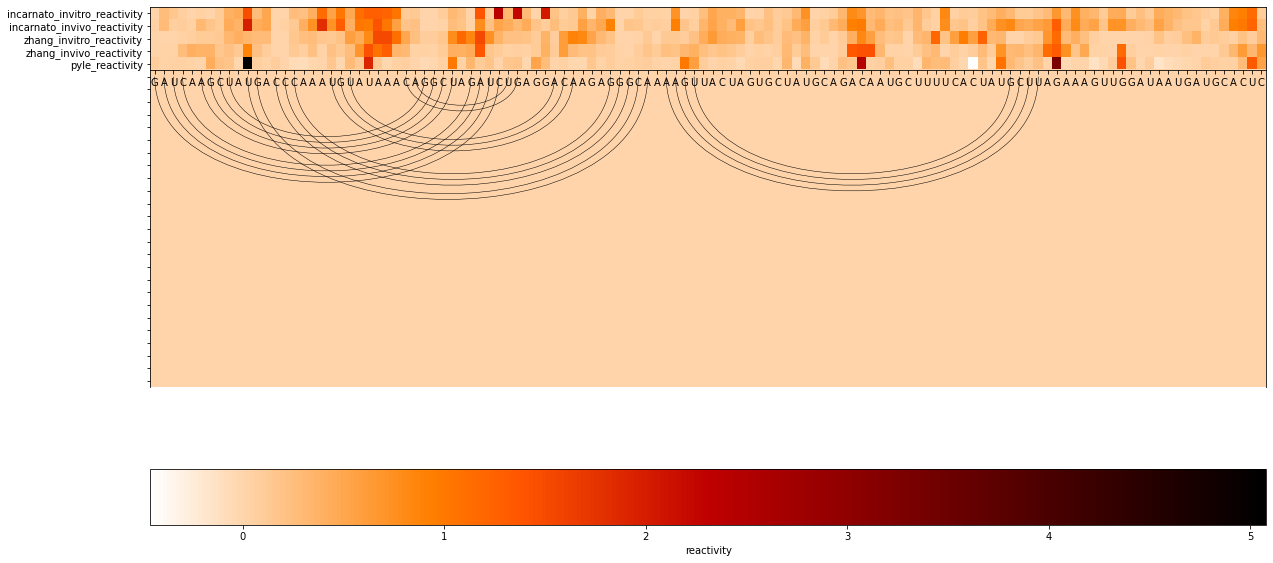

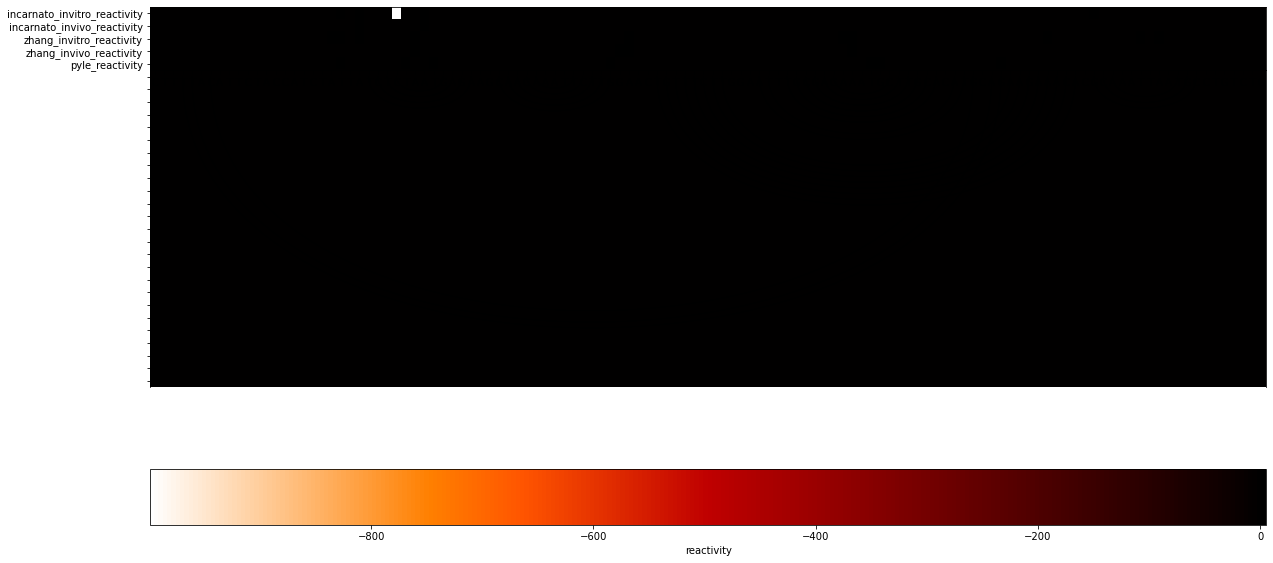

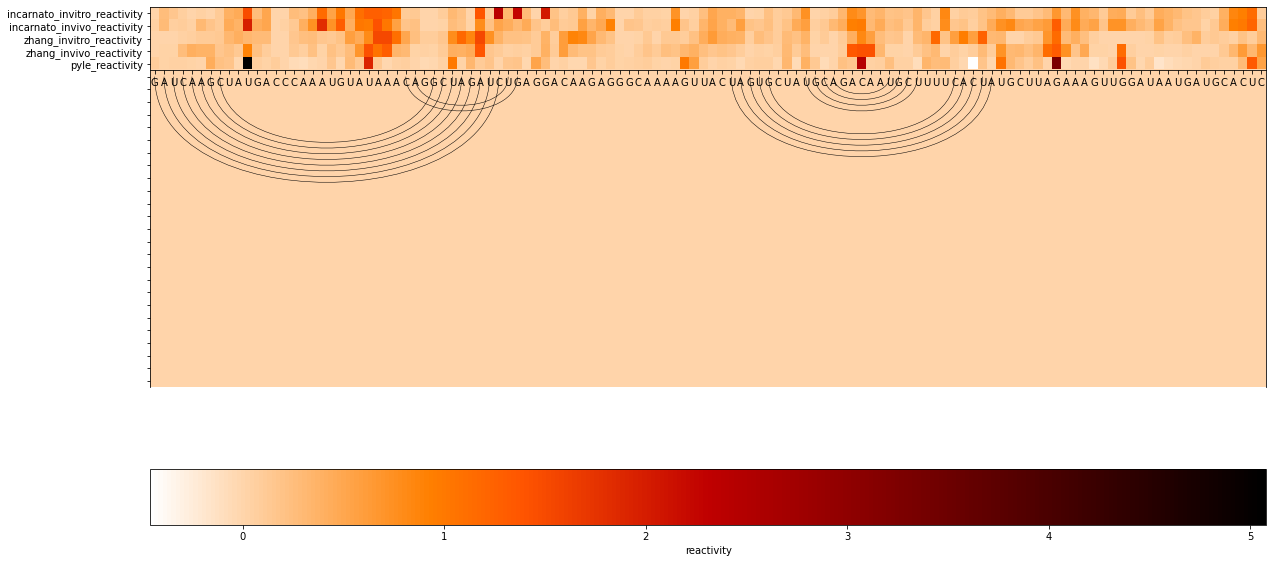

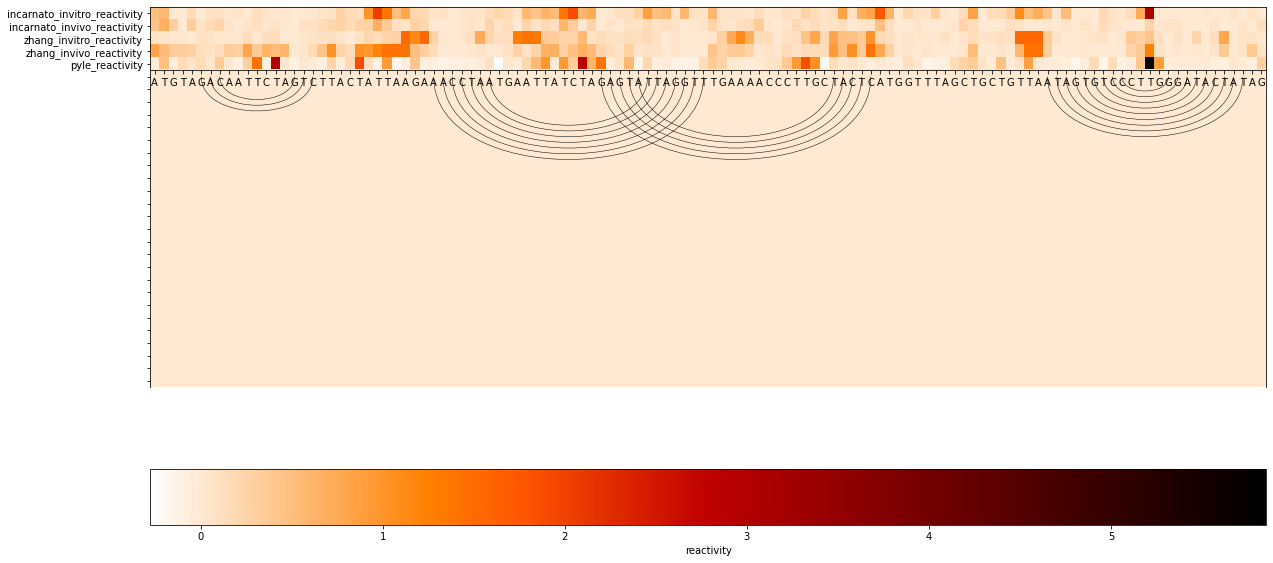

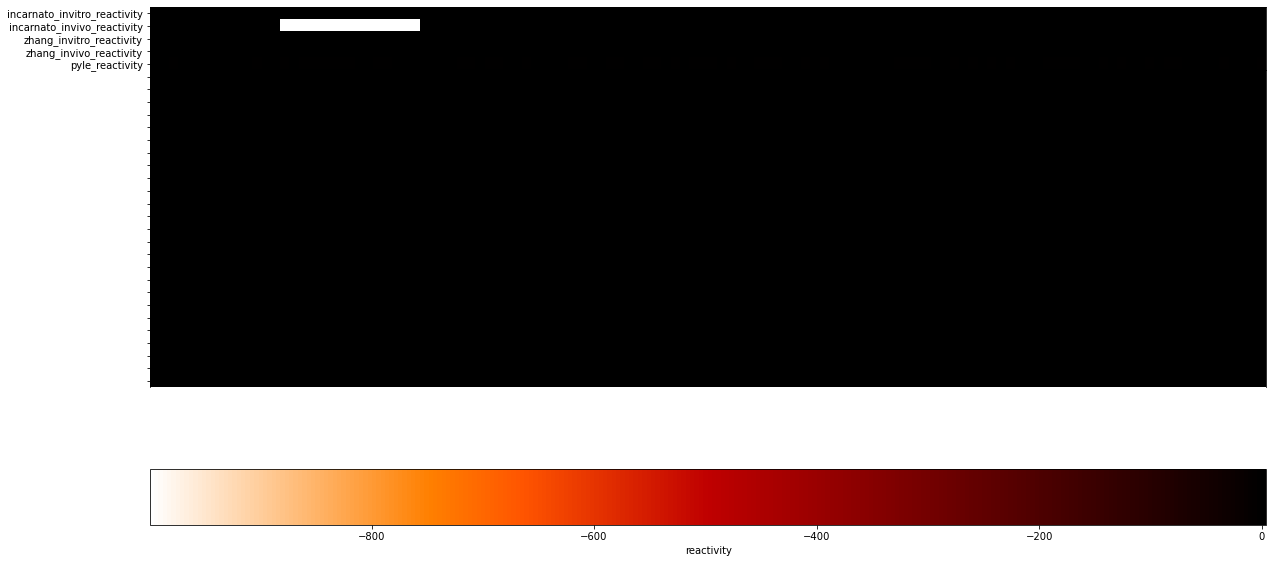

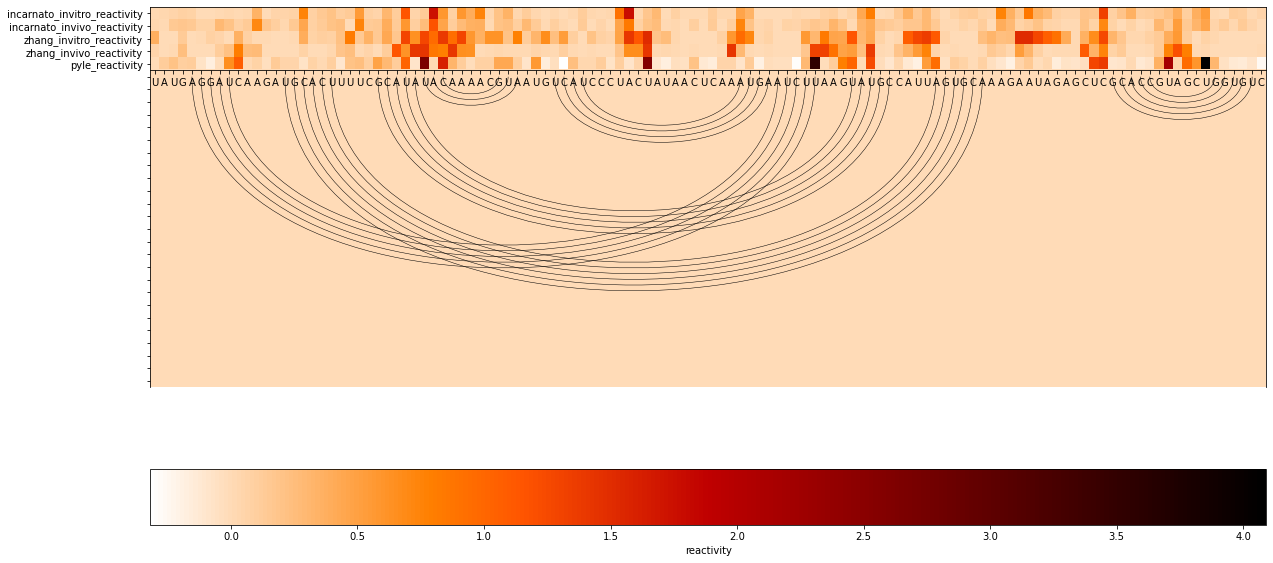

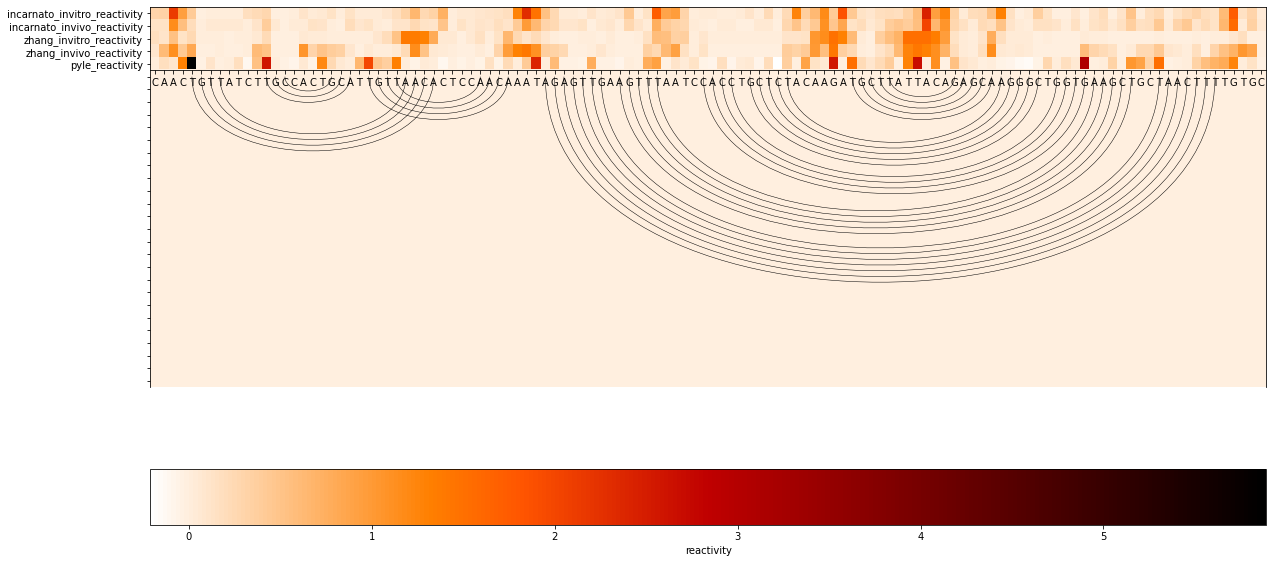

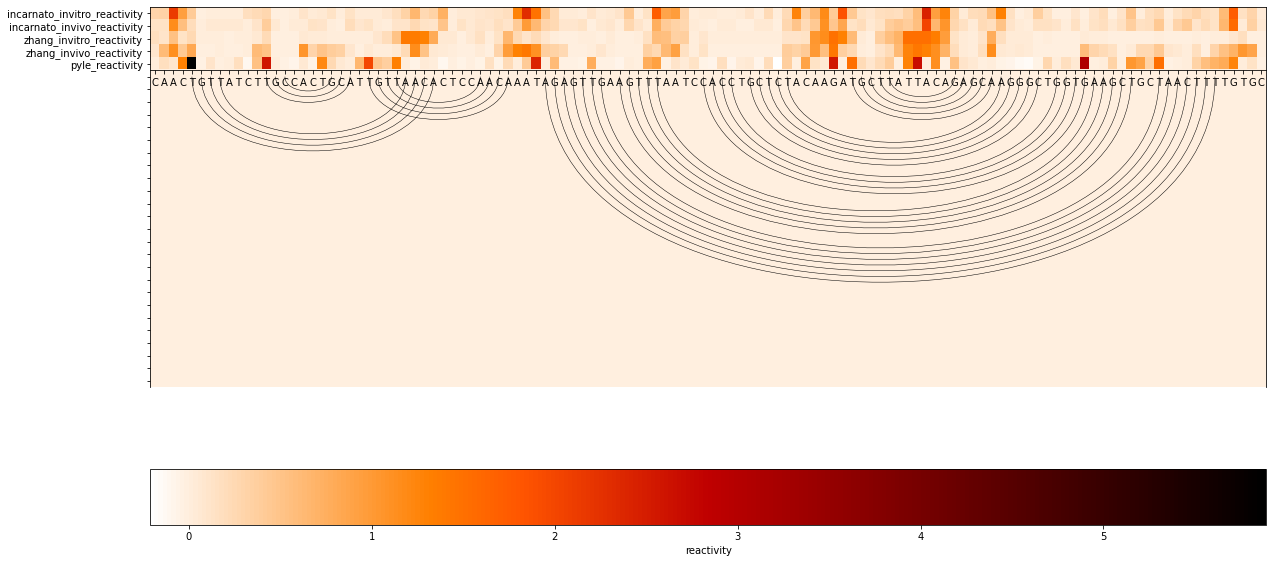

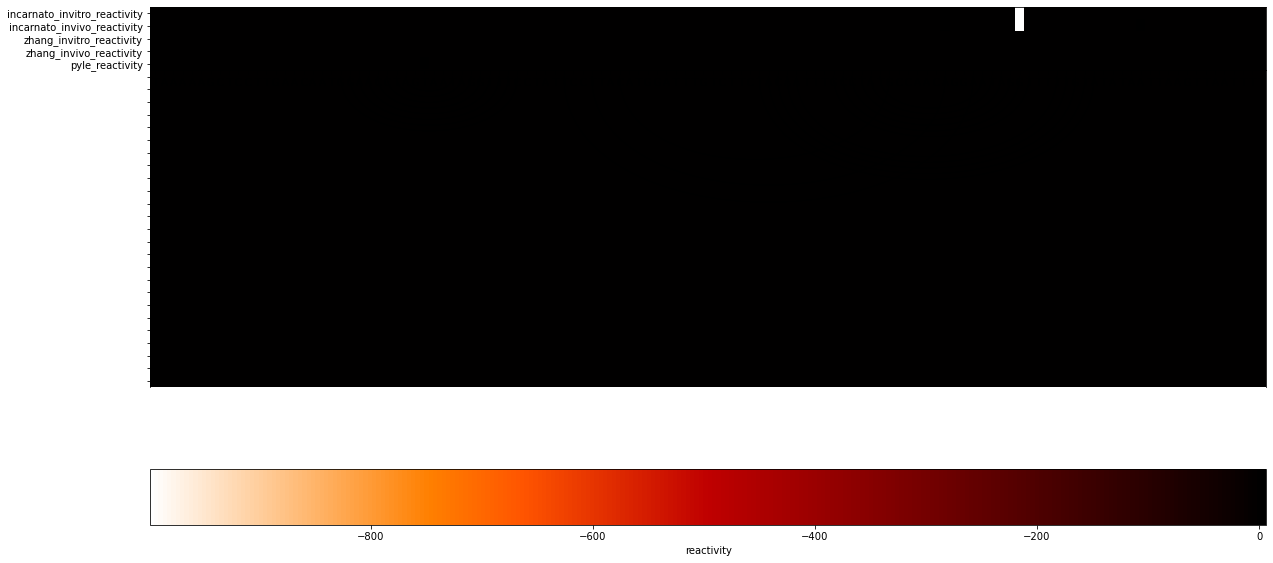

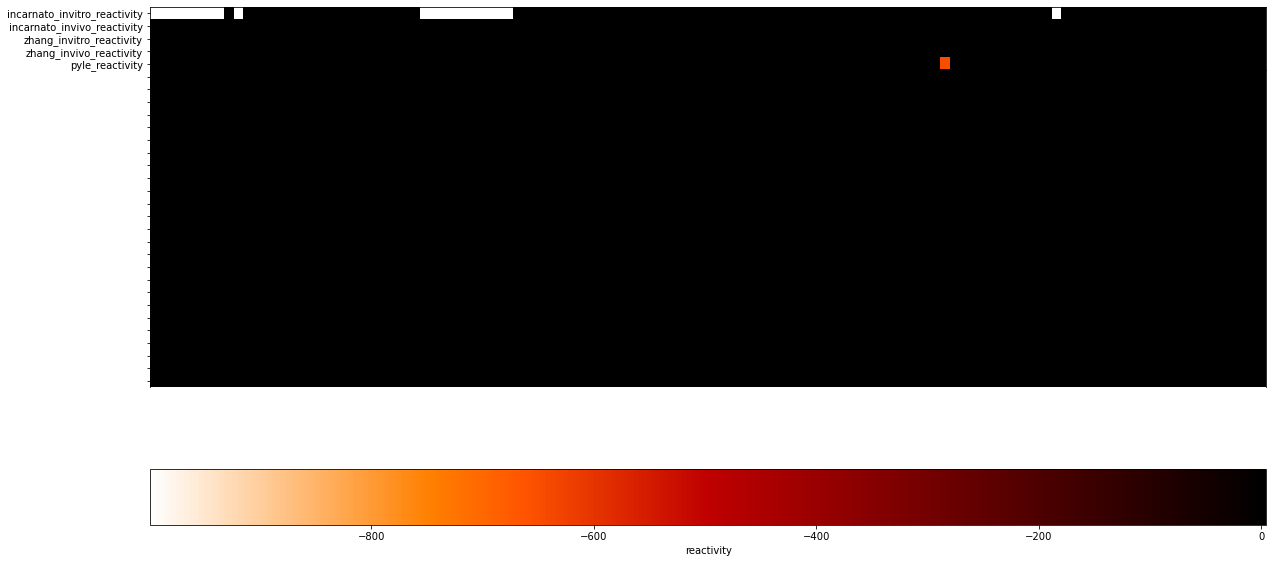

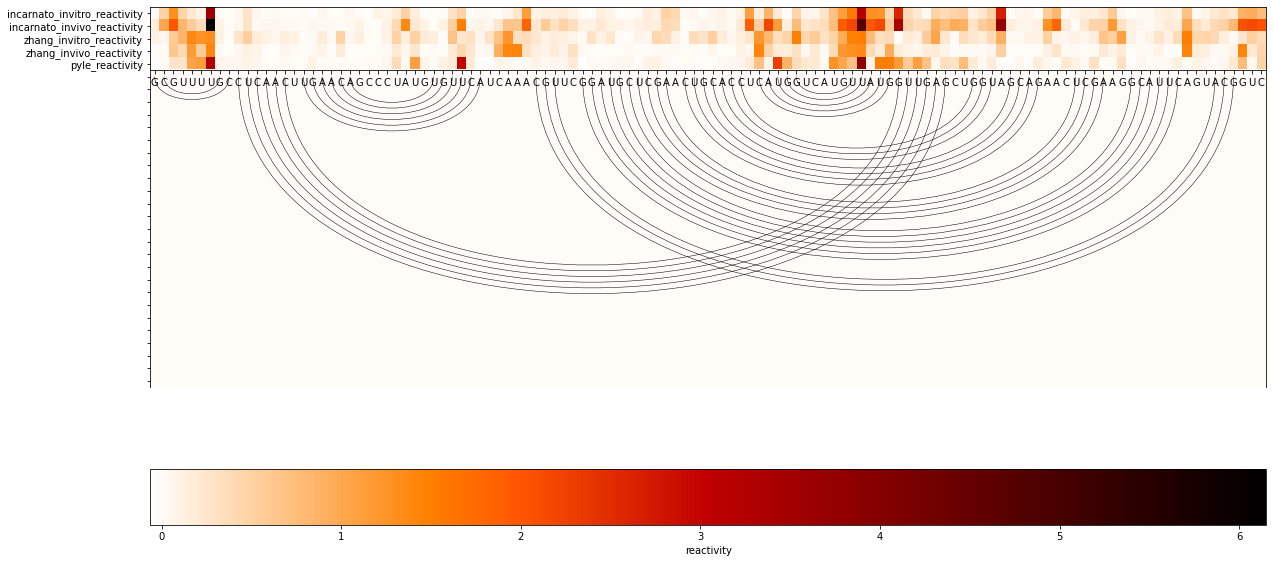

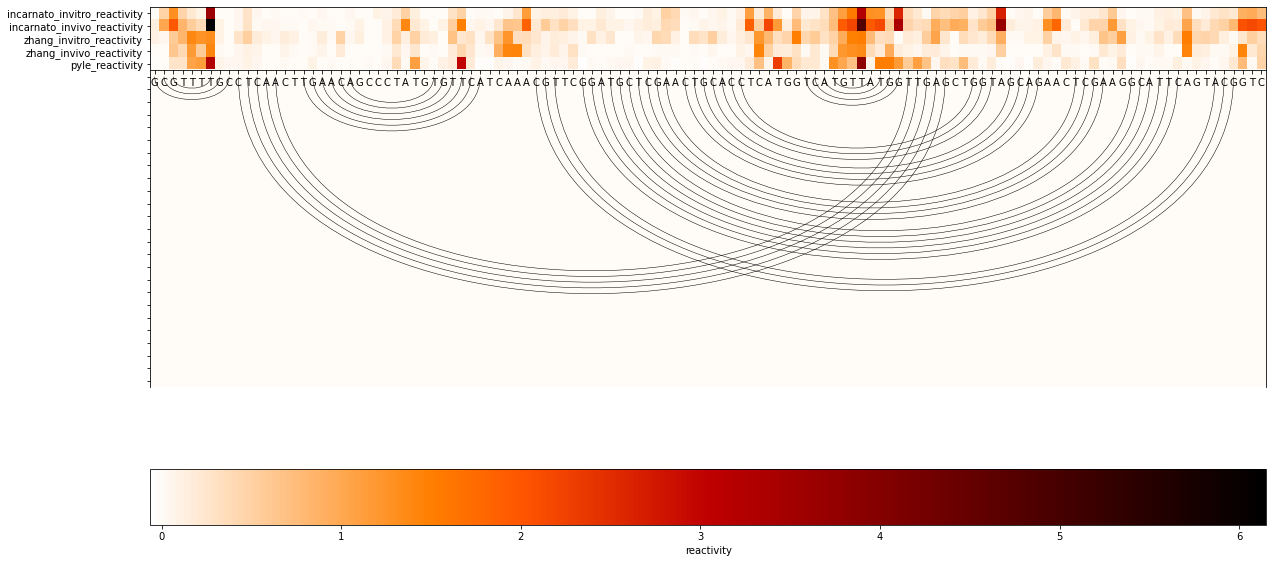

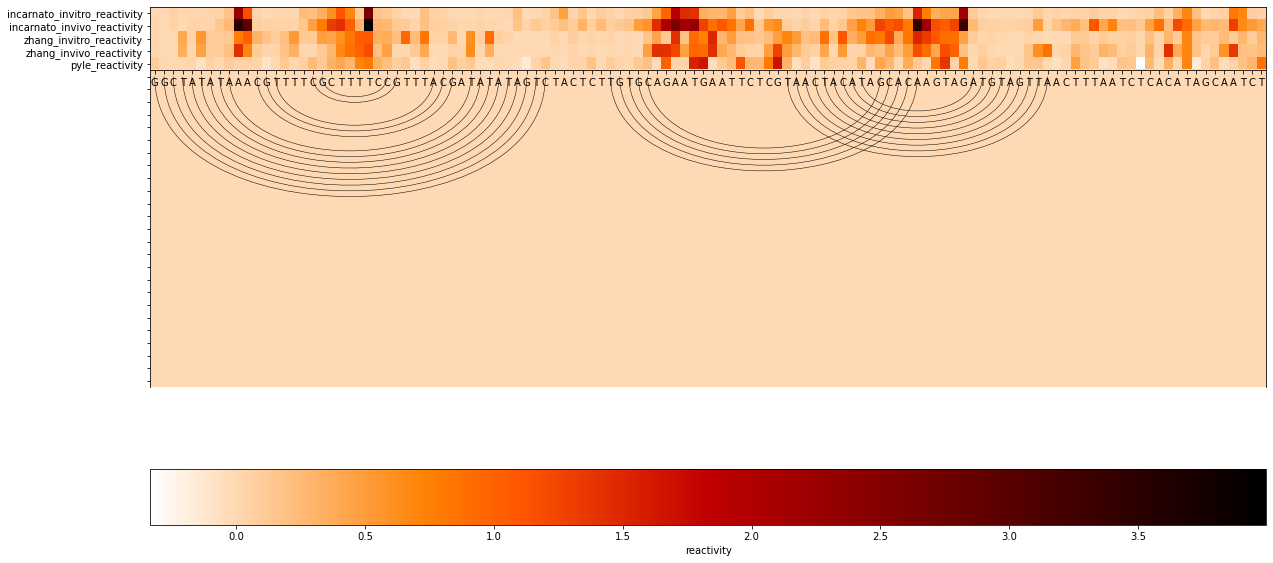

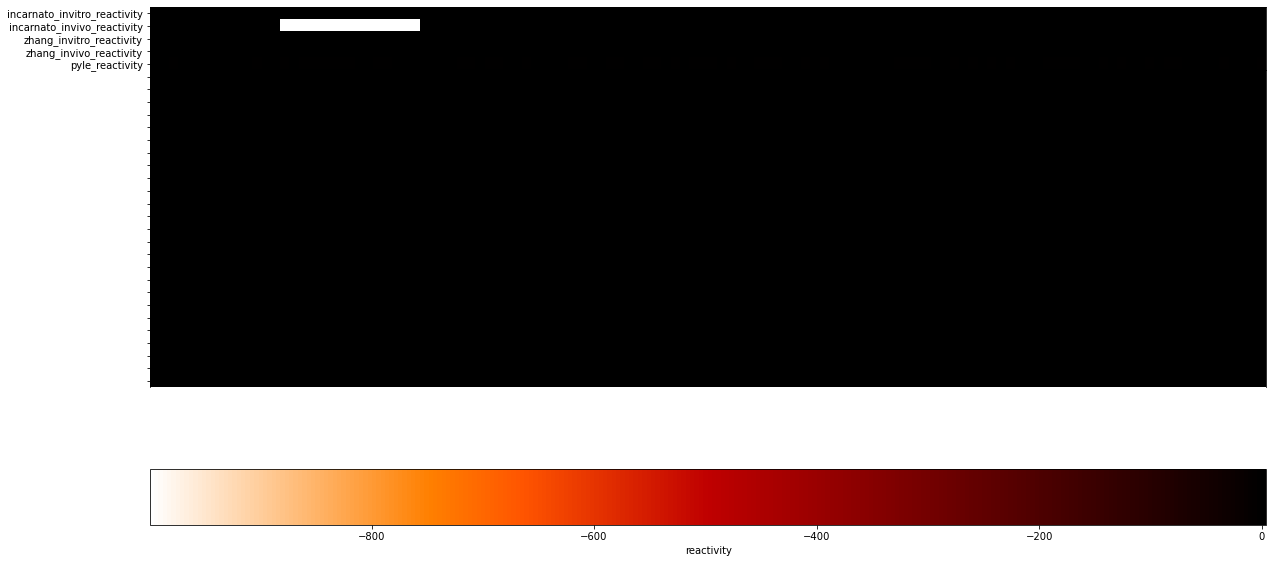

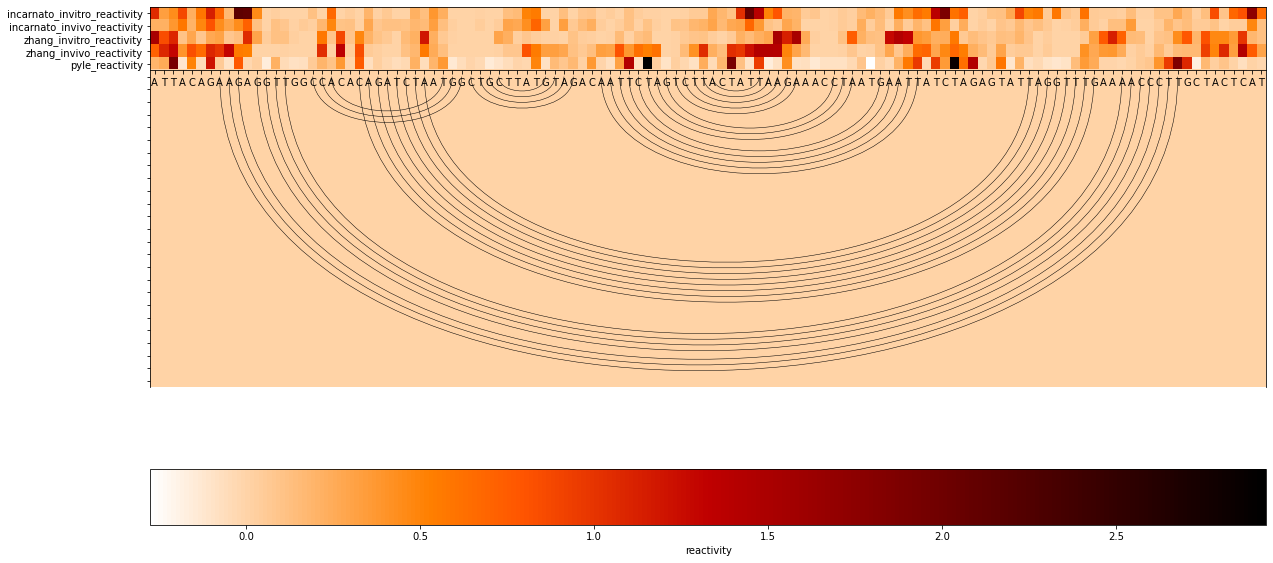

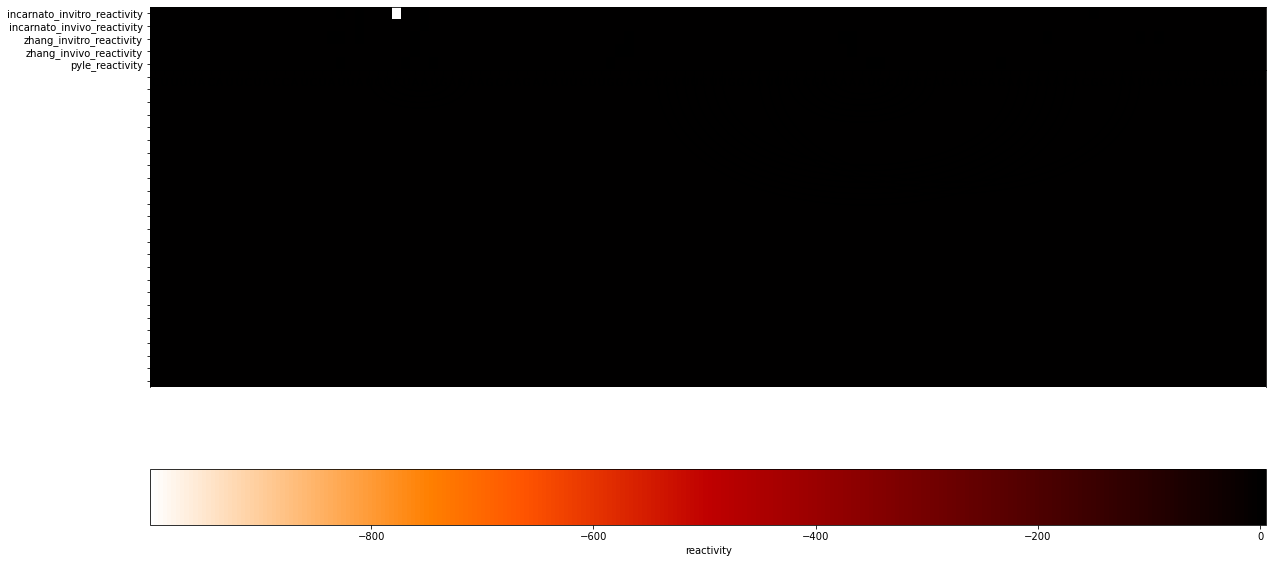

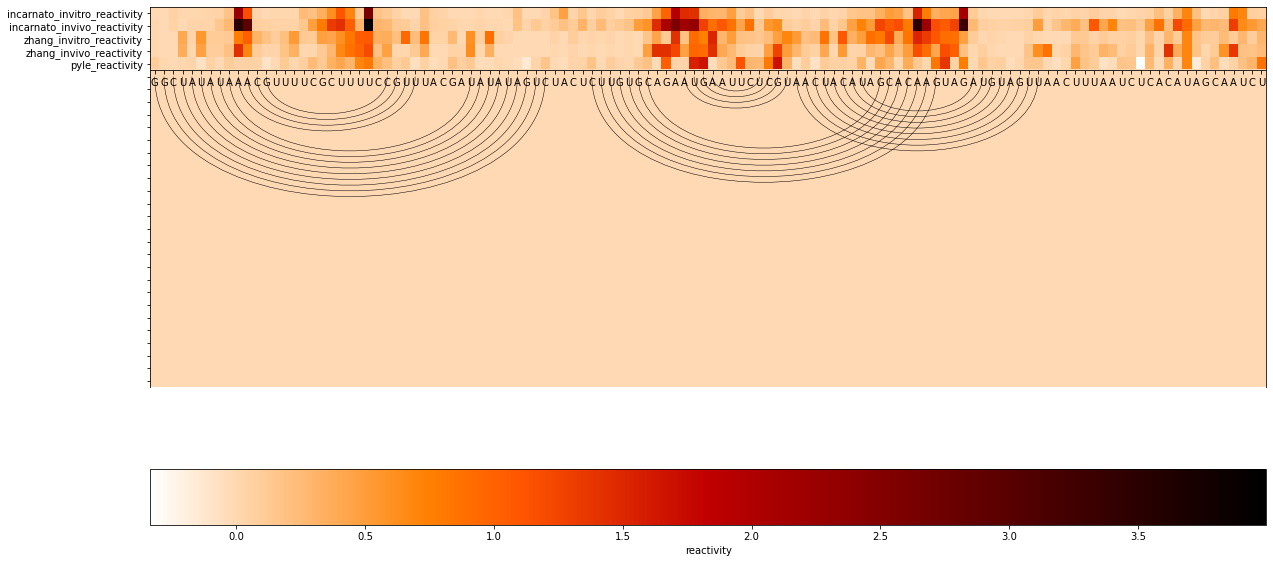

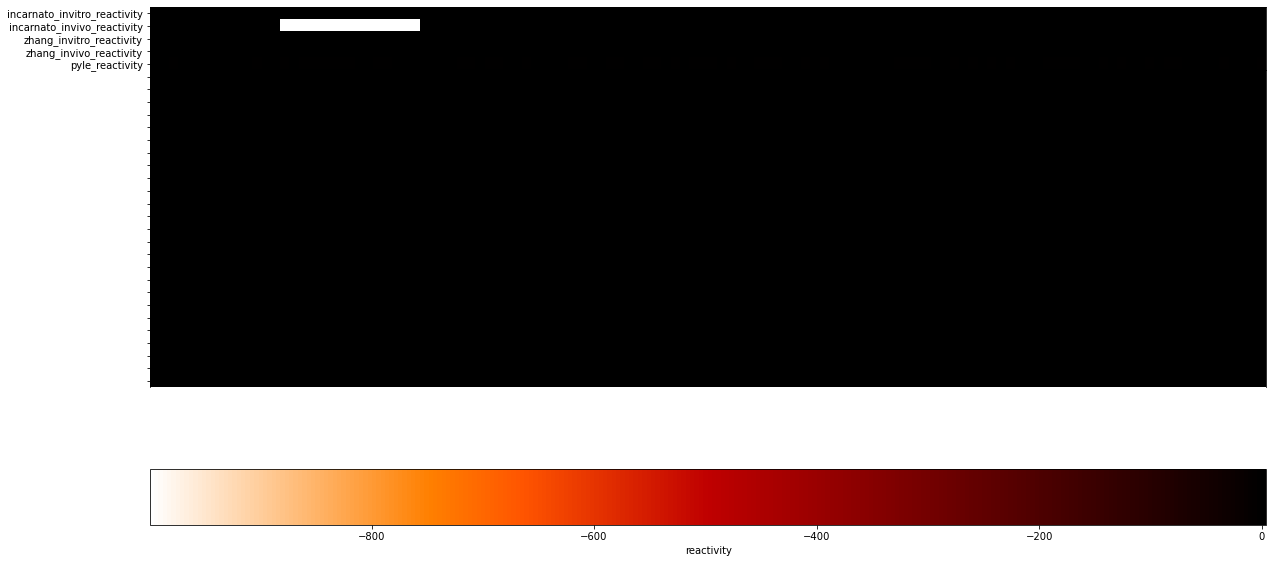

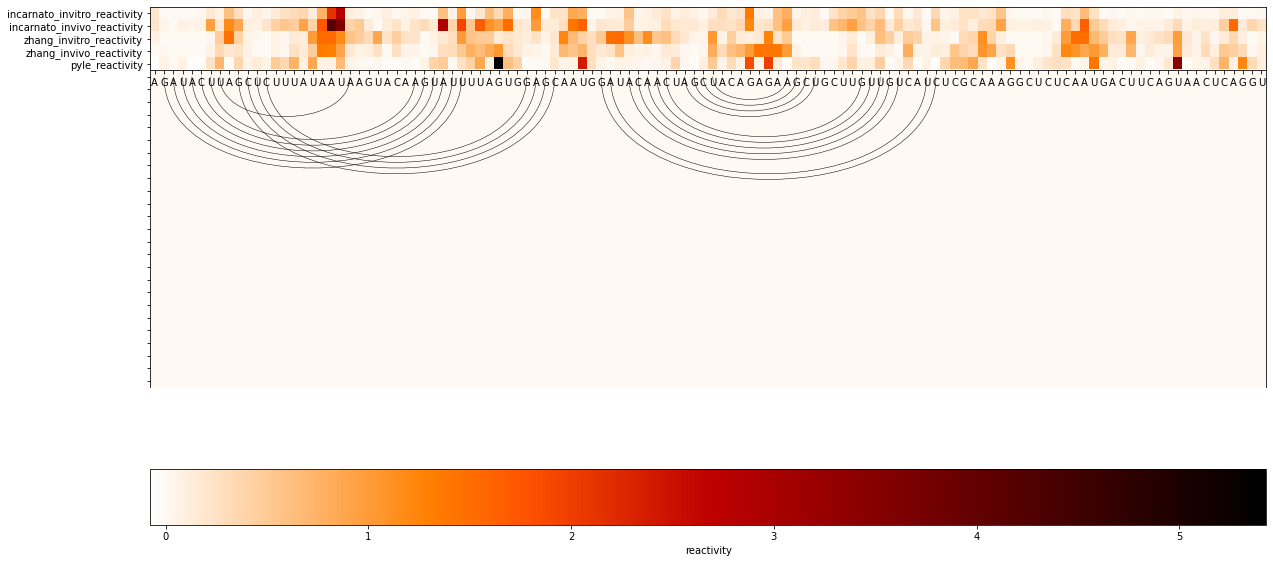

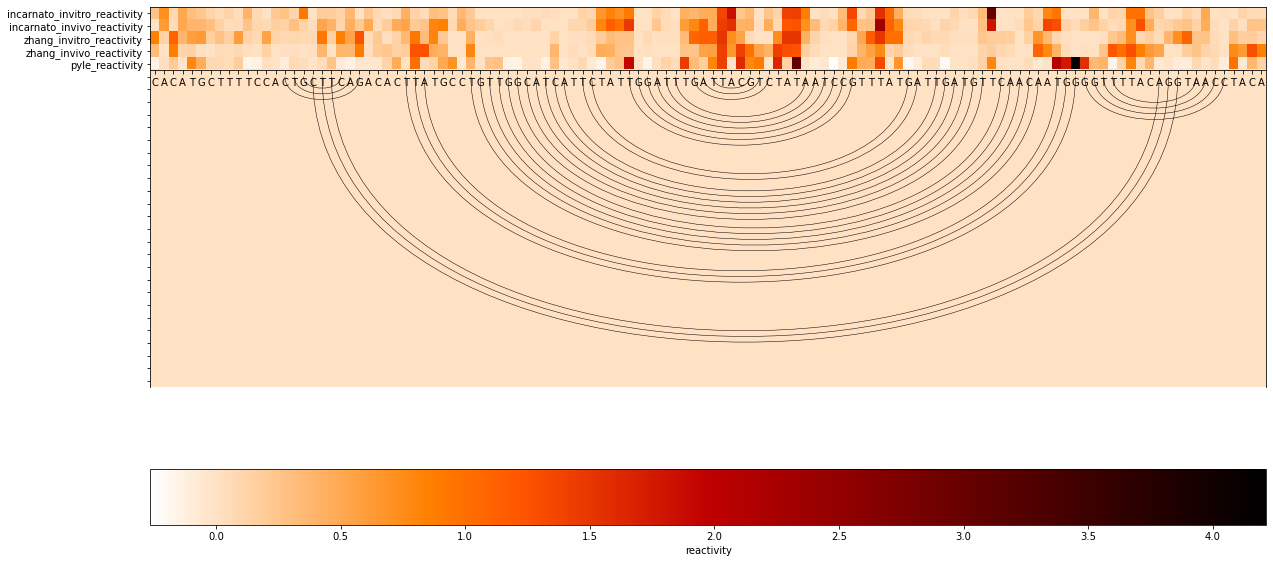

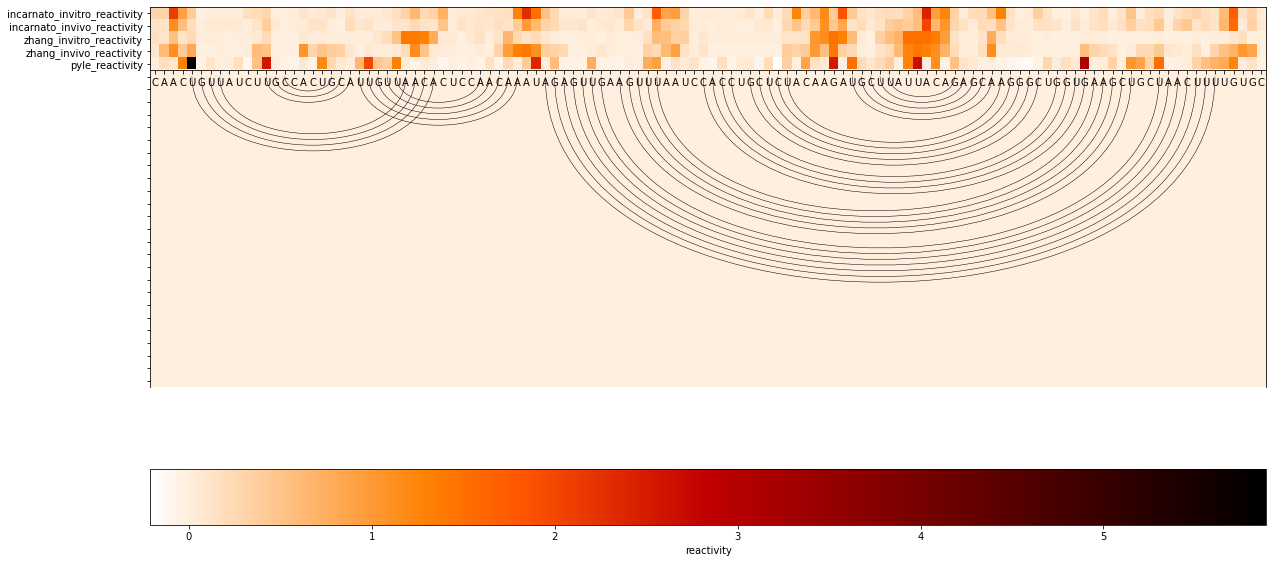

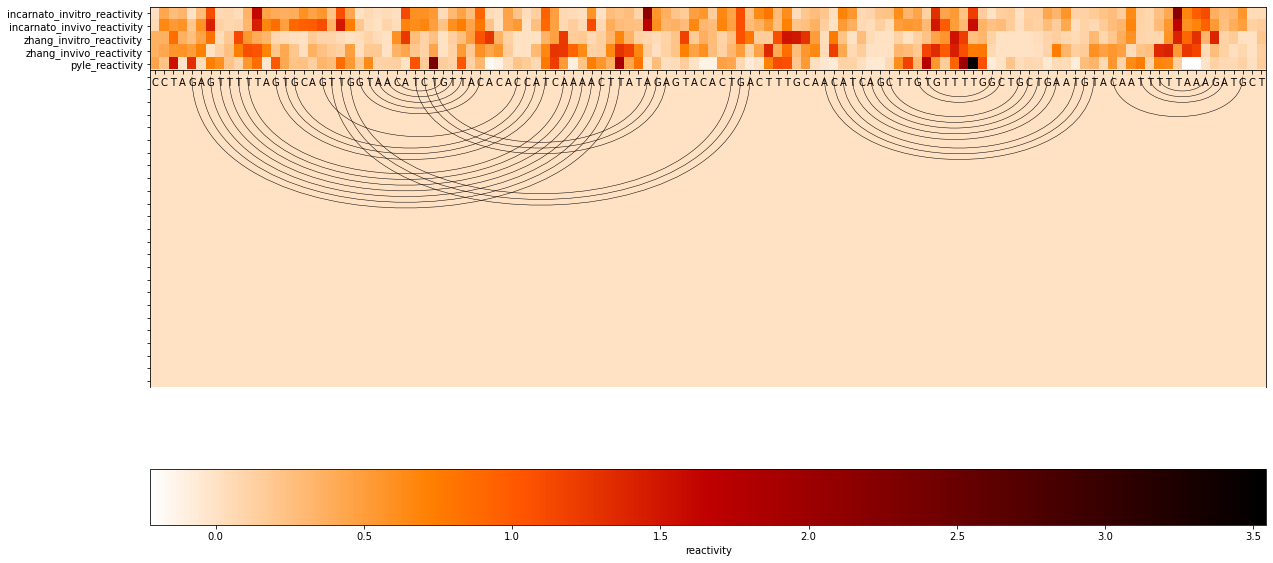

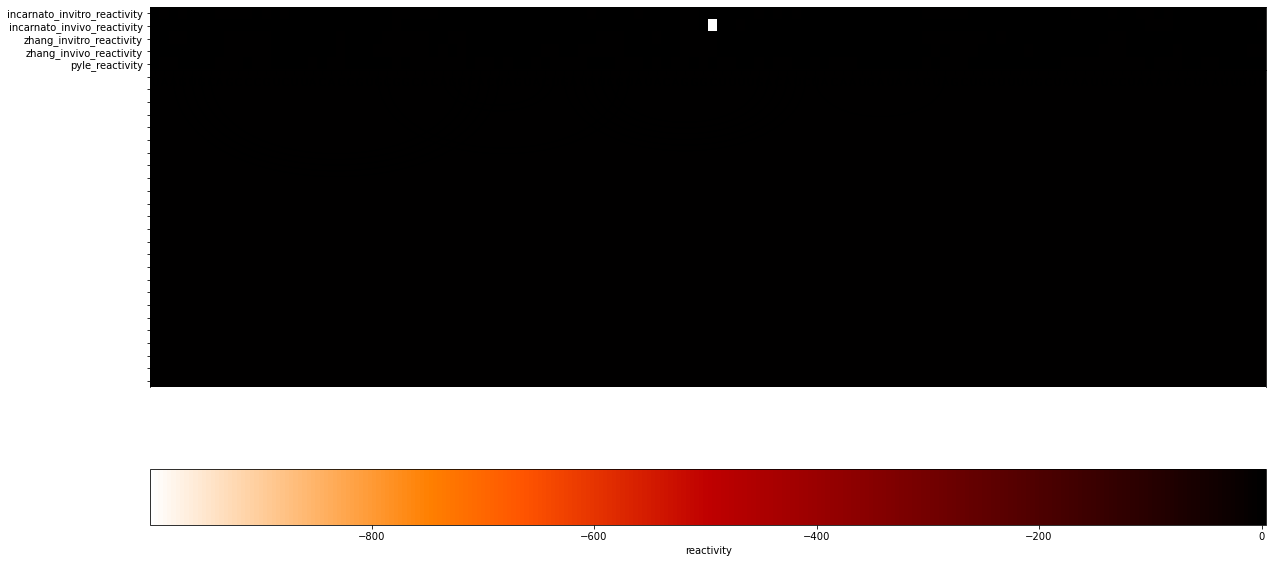

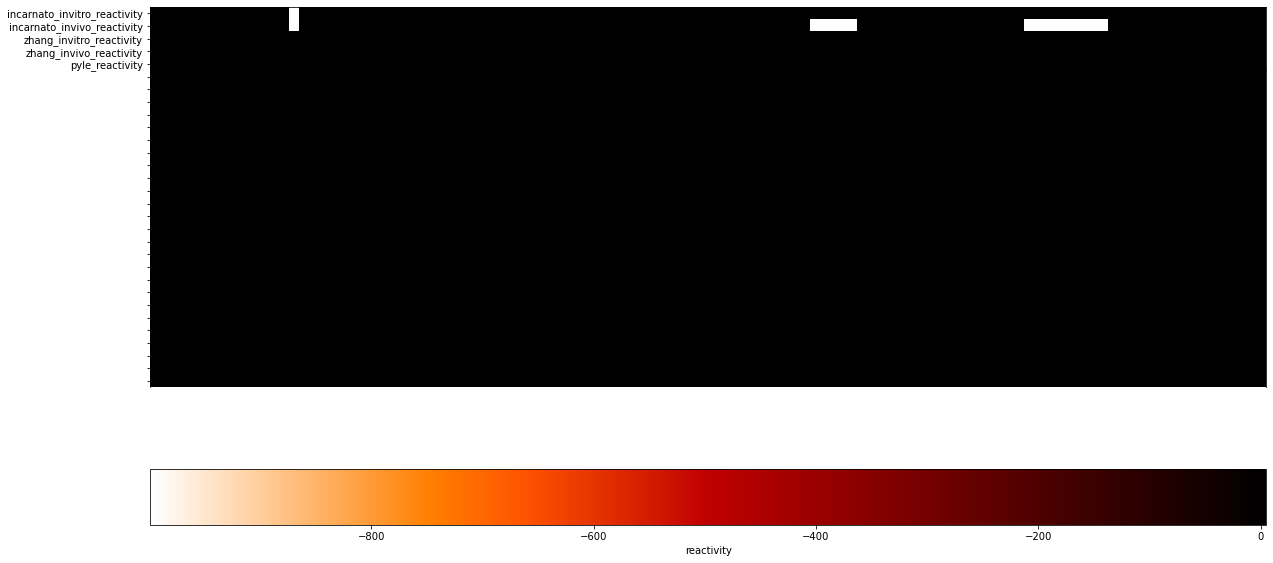

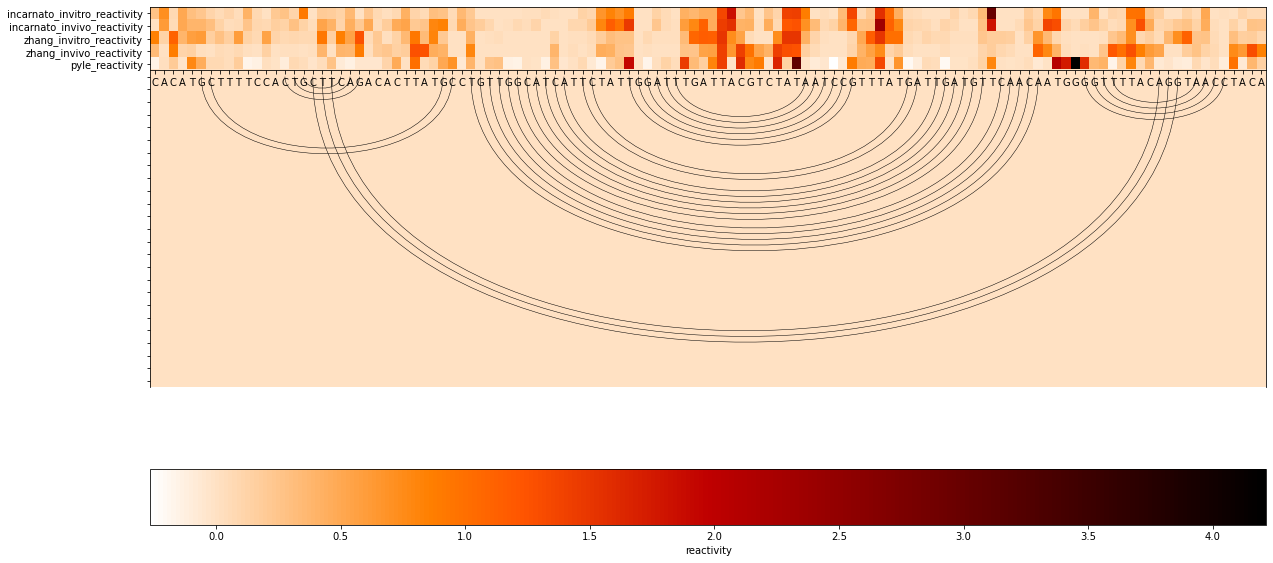

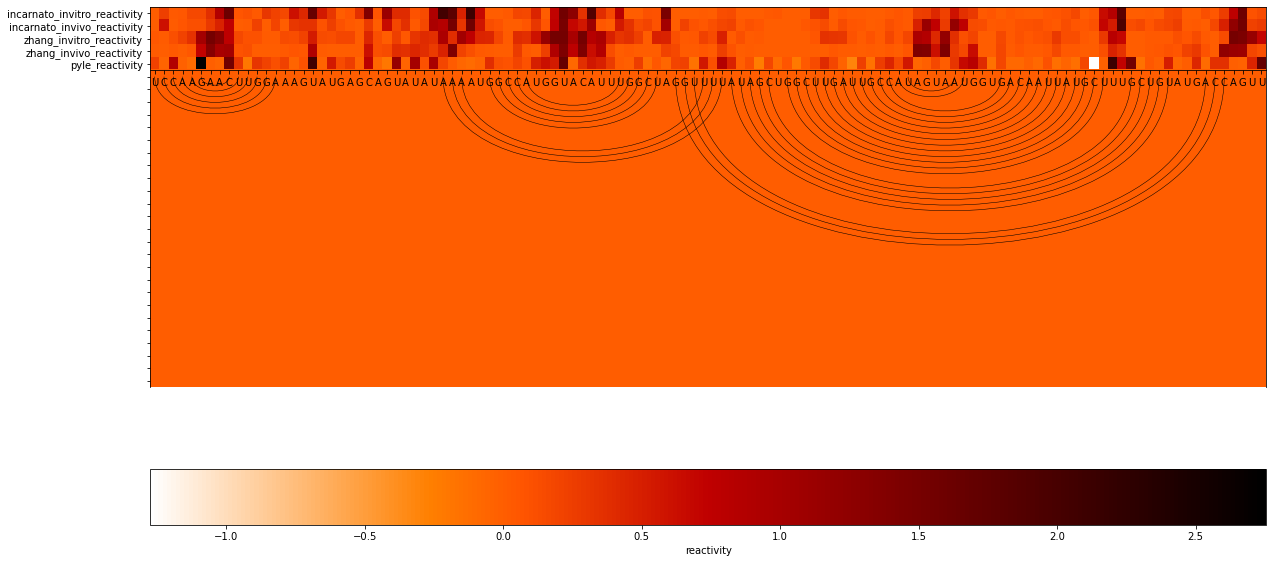

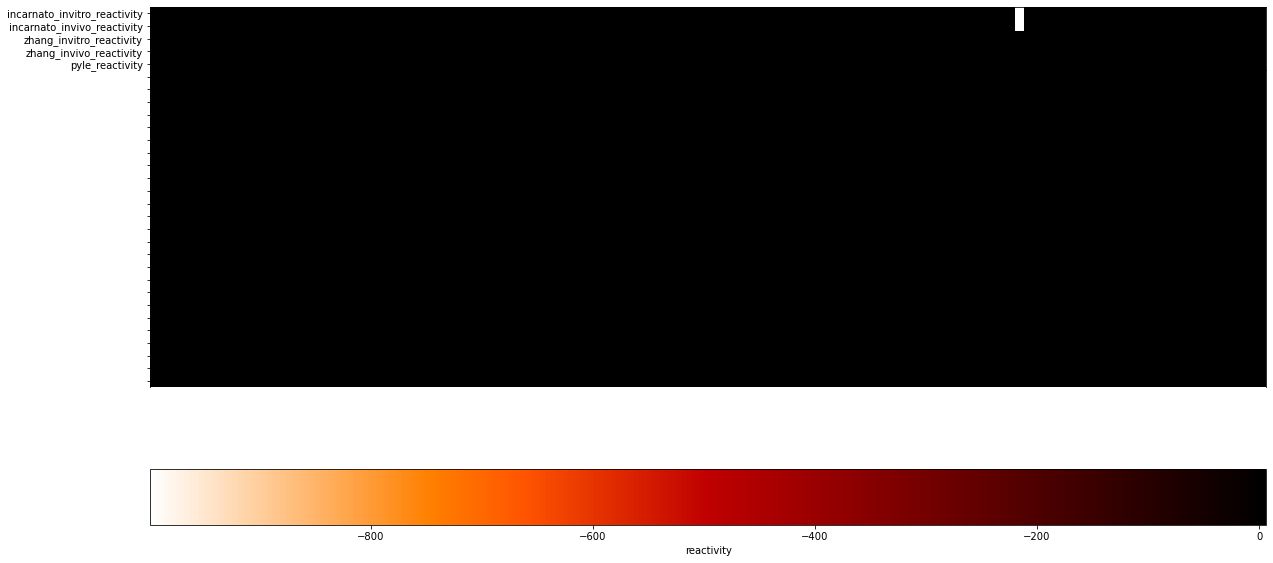

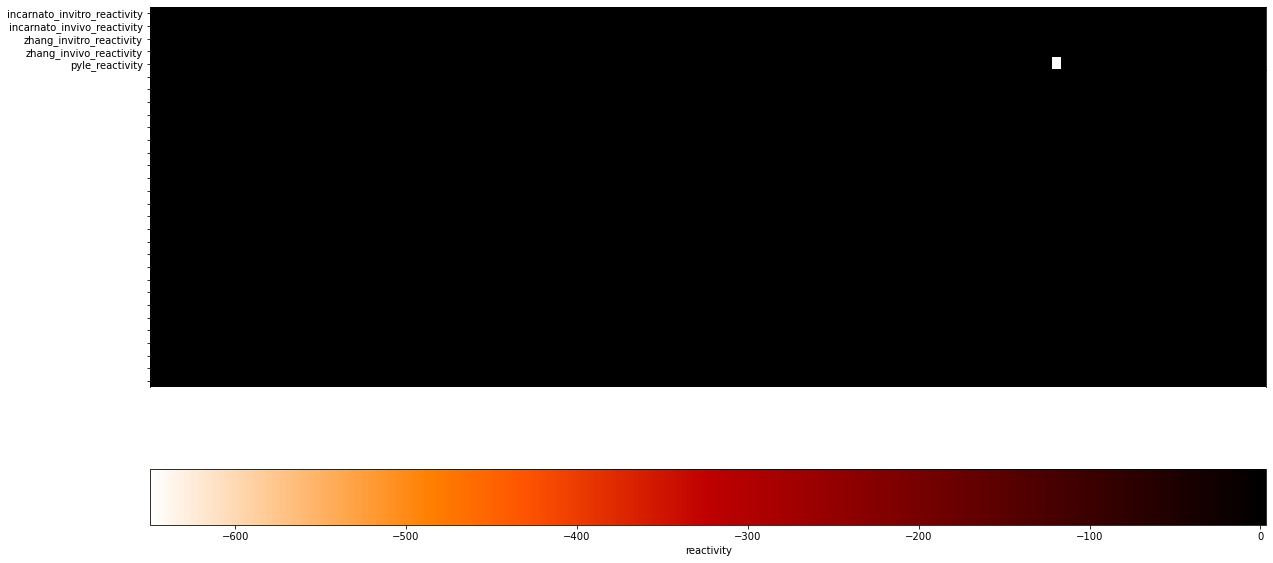

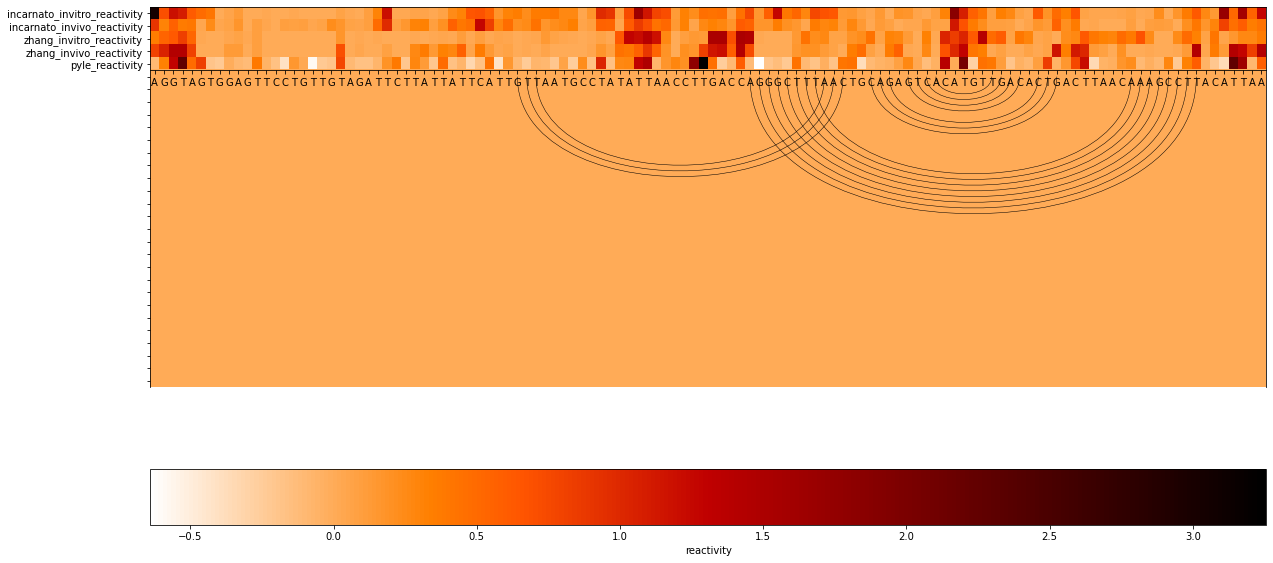

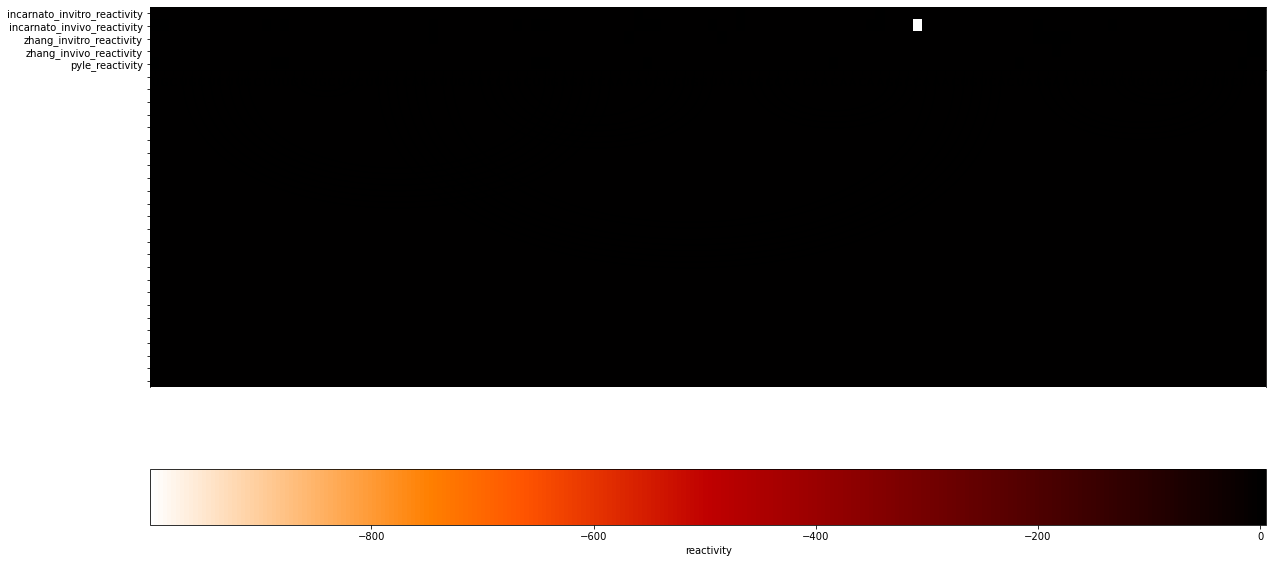

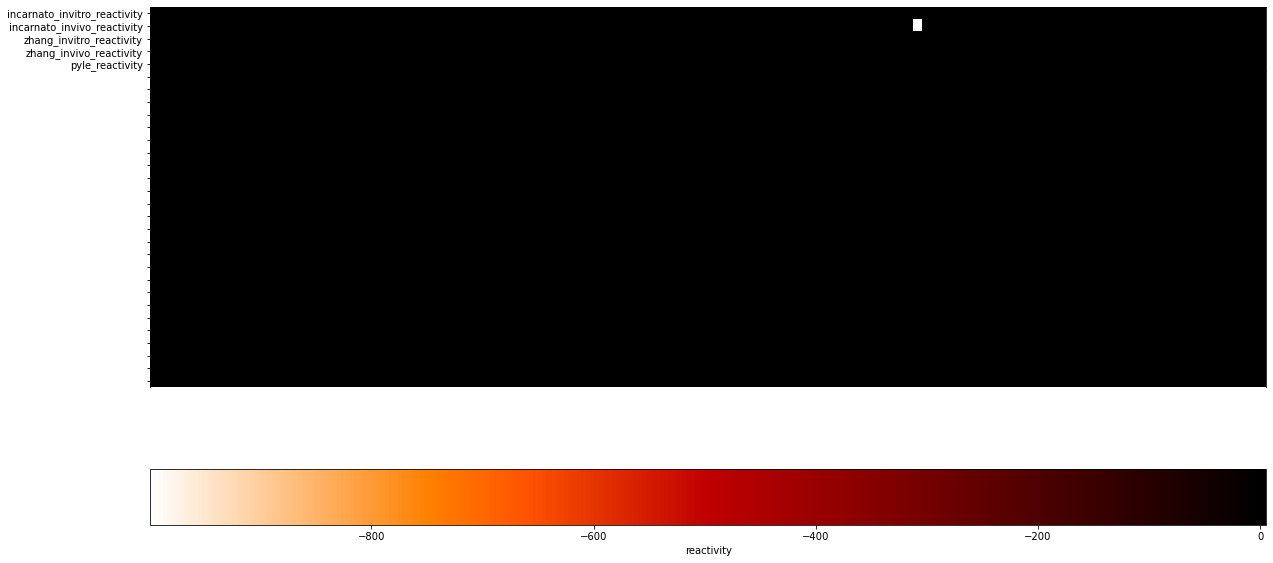

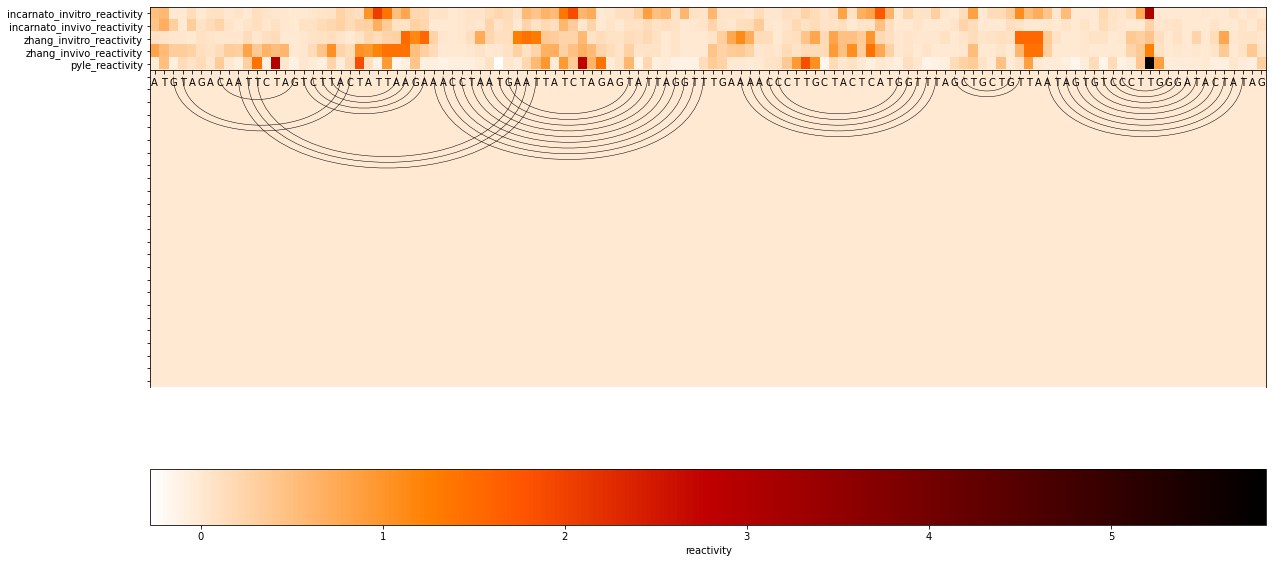

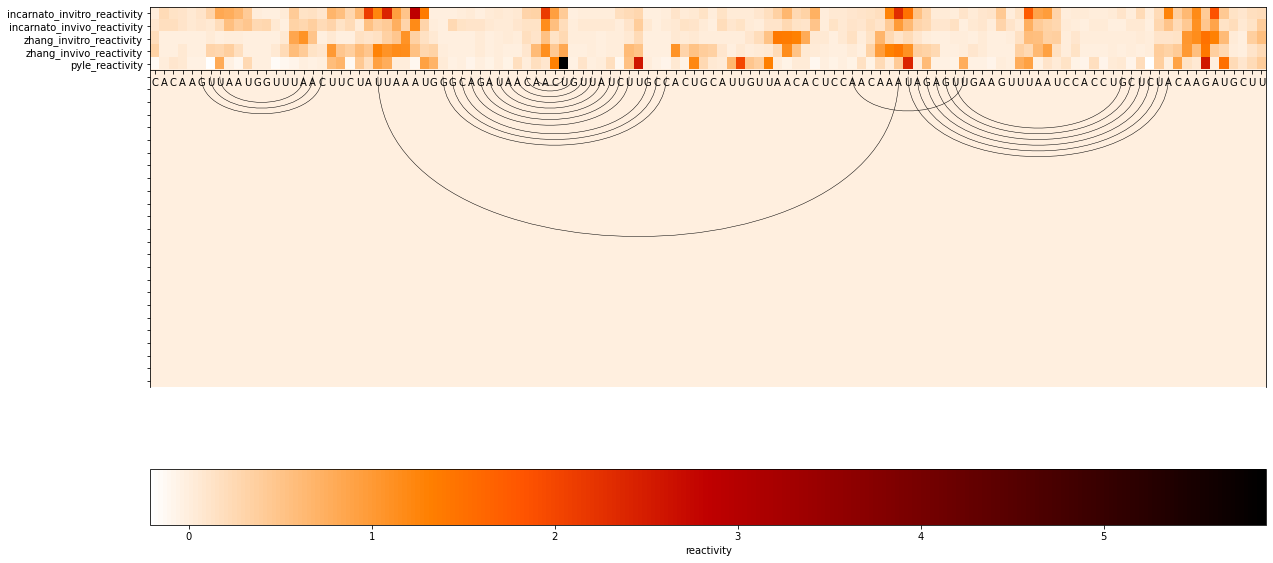

In [35]:
top_pks = '/home/gnye8/Desktop/PK_research/pipeline_results/analysis_output/top_pks.csv'
path = '/home/gnye8/Desktop/PK_research/SSRP_work/shape_data'
shape_sets = ['incarnato_invitro_reactivity', 'incarnato_invivo_reactivity', 'zhang_invitro_reactivity', 'zhang_invivo_reactivity', 'pyle_reactivity']
folder = '/home/gnye8/Desktop/PK_research/pipeline_results/normalized_shape_analysis'


get_shape_graphs_for_pks(pk_csv=top_pks, path_to_shape_data=path, list_of_shape_sets=shape_sets, output_folder=folder)

In [61]:
def get_normalized_shape_data(shape_filename):

    # write shape text file to list
    shape_file = open("{}".format(shape_filename), "r")
    shape_data = shape_file.read()
    shape_data_list = shape_data.split("\n")
    shape_file.close()
    
    shape_data_list.remove('')

    #convert unknown values to string 'nan'
    shape_nan_list = shape_lines_unnorm(shape_data_list)
    
    #convert string 'nan' to np.nan
    shape_reacs = []
    for char in shape_nan_list:
        if char == 'nan':
            shape_reacs.append(np.nan)
        else:
            shape_reacs.append(char)
    
    # normalize shape data
    normalized_shape_data = normalize_shape(shape_reacs).tolist()
    return normalized_shape_data

In [62]:
pyle = get_normalized_shape_data('/home/gnye8/Desktop/PK_research/SSRP_work/shape_data/pyle_reactivity-Copy1.csv')

In [63]:
print(type(pyle))lppp

<class 'list'>
